In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

### Đọc file csv và gắn index với giá Close

In [2]:
df = pd.read_csv('BNB2019-2024.csv')
df1 = df['Close']

#### Chuẩn hóa dữ liệu về khoảng [0, 1].

In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

#### Chia dữ liệu thành tập huấn luyện, kiểm tra và xác thực.

In [4]:
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

print(train_data.shape, test_data.shape)

(1452, 1) (363, 1)


#### Tạo dữ liệu dạng thời gian (sequence) cho RNN.

In [5]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]      ###i=0, X=0,1,2,3-----99   Y=100    
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

#### Tạo các mẫu dữ liệu thành X=t,t+1,t+2..t+99 and Y=t+100

In [6]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

#### Định hình lại dữ liệu để phù hợp với mô hình RNN.

In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#### Xây dựng mô hình RNN

In [8]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

### Huấn luyện mô hình trên tập huấn luyện.

In [9]:
model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs=100, batch_size=64,verbose=1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1043 - val_loss: 7.1296e-04
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017 - val_loss: 4.4832e-04
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012 - val_loss: 2.8442e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012 - val_loss: 2.7704e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - val_loss: 4.6399e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - val_loss: 5.4223e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012 - val_loss: 2.1310e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.9697e-04 - val_loss: 6.0593e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 2.0187e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.2700e-04 - val_loss: 3.1325e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.1958e-04 - val_loss: 2.3468e

#### Dự báo dữ liệu test, val

In [10]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


#### Chuẩn hóa dữ liệu train_predict, y_pred, y_pred_val

In [11]:
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

#### Đánh giá độ chính xác thuật toán

In [12]:
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 251.29383686364272


In [13]:
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

Testing MAPE: 70277.52987597334


In [14]:
test_mse = np.mean((y_pred - ytest) ** 2)
print('Testing MSE:', test_mse)

Testing MSE: 63148.59244565108


####  Dự báo 30 ngày 

In [15]:
from numpy import array

x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.36274506 0.36325421 0.35757867 0.34811602 0.3495097  0.36675674
 0.35025292 0.35323429 0.35354256 0.35599945 0.36657625 0.3258307
 0.340314   0.33675585 0.33545785 0.33776761 0.3341765  0.32723409
 0.3306432  0.32711594 0.3276278  0.32892126 0.33005469 0.32824974
 0.3360497  0.33299709 0.33024014 0.33557263 0.34448539 0.34276336
 0.34571182 0.35574894 0.36786681 0.36475761 0.36643537 0.35346403
 0.35264237 0.34507417 0.34813608 0.36507858 0.37629004 0.39300811
 0.39320309 0.3932248  0.38320847 0.38674482 0.43270004 0.47169776
 0.47158018 0.45699175 0.46192565 0.45482597 0.4577865  0.45432788
 0.46116786 0.4715817  0.46235201 0.44786031 0.4405003  0.44291643
 0.43762707 0.44381158 0.44922158 0.431105   0.43950489 0.43473831
 0.46252757 0.45901412 0.44979772 0.45611245 0.45762464 0.46161676
 0.46365535 0.44432213 0.43376663 0.42579351 0.42403432 0.43964101
 0.44490418 0.44362965 0.452233   0.4473624  0.436689   0.4364261
 0.43789551 0.43576697 0.44326727 0.43744386 0.44022

0 day output [[0.5243253]]
1 day input [0.36325421 0.35757867 0.34811602 0.3495097  0.36675674 0.35025292
 0.35323429 0.35354256 0.35599945 0.36657625 0.3258307  0.340314
 0.33675585 0.33545785 0.33776761 0.3341765  0.32723409 0.3306432
 0.32711594 0.3276278  0.32892126 0.33005469 0.32824974 0.3360497
 0.33299709 0.33024014 0.33557263 0.34448539 0.34276336 0.34571182
 0.35574894 0.36786681 0.36475761 0.36643537 0.35346403 0.35264237
 0.34507417 0.34813608 0.36507858 0.37629004 0.39300811 0.39320309
 0.3932248  0.38320847 0.38674482 0.43270004 0.47169776 0.47158018
 0.45699175 0.46192565 0.45482597 0.4577865  0.45432788 0.46116786
 0.4715817  0.46235201 0.44786031 0.4405003  0.44291643 0.43762707
 0.44381158 0.44922158 0.431105   0.43950489 0.43473831 0.46252757
 0.45901412 0.44979772 0.45611245 0.45762464 0.46161676 0.46365535
 0.44432213 0.43376663 0.42579351 0.42403432 0.43964101 0.44490418
 0.44362965 0.452233   0.4473624  0.436689   0.4364261  0.43789551
 0.43576697 0.44326727 0.43

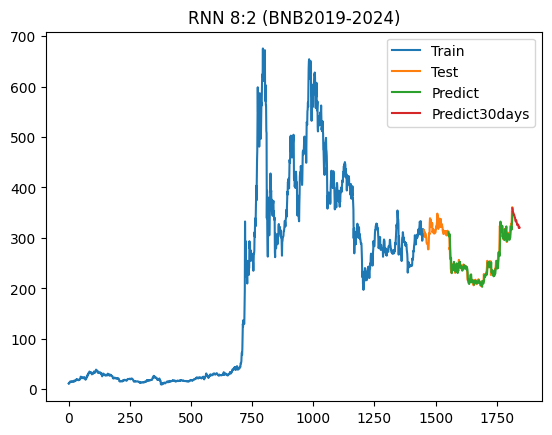

In [16]:
plt.title('RNN 8:2 (BNB2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

#### Dự báo 60 ngày

In [17]:
y_input = test_data[60:].reshape(1, -1)
y_input.shape

temp_input = list(y_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 60):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        y_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, y_input))
        y_input = y_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(y_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        y_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(y_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.36274506 0.36325421 0.35757867 0.34811602 0.3495097  0.36675674
 0.35025292 0.35323429 0.35354256 0.35599945 0.36657625 0.3258307
 0.340314   0.33675585 0.33545785 0.33776761 0.3341765  0.32723409
 0.3306432  0.32711594 0.3276278  0.32892126 0.33005469 0.32824974
 0.3360497  0.33299709 0.33024014 0.33557263 0.34448539 0.34276336
 0.34571182 0.35574894 0.36786681 0.36475761 0.36643537 0.35346403
 0.35264237 0.34507417 0.34813608 0.36507858 0.37629004 0.39300811
 0.39320309 0.3932248  0.38320847 0.38674482 0.43270004 0.47169776
 0.47158018 0.45699175 0.46192565 0.45482597 0.4577865  0.45432788
 0.46116786 0.4715817  0.46235201 0.44786031 0.4405003  0.44291643
 0.43762707 0.44381158 0.44922158 0.431105   0.43950489 0.43473831
 0.46252757 0.45901412 0.44979772 0.45611245 0.45762464 0.46161676
 0.46365535 0.44432213 0.43376663 0.42579351 0.42403432 0.43964101
 0.44490418 0.44362965 0.452233   0.4473624  0.436689   0.4364261
 0.43789551 0.43576697 0.44326727 0.43744386 0.44022

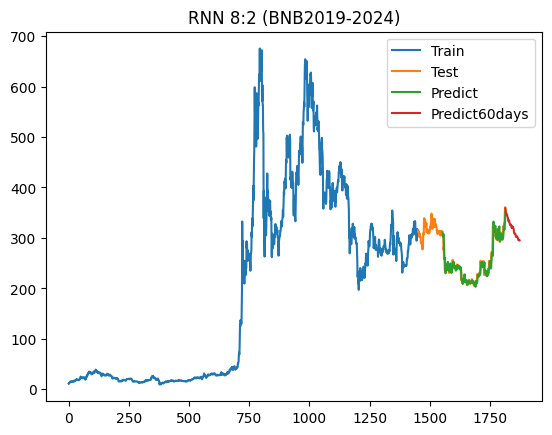

In [18]:
plt.title('RNN 8:2 (BNB2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

#### Dự báo 90 ngày

In [19]:
z_input = test_data[60:].reshape(1, -1)
z_input.shape

temp_input = list(z_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        z_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, z_input))
        z_input = z_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(z_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        z_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(z_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.36274506 0.36325421 0.35757867 0.34811602 0.3495097  0.36675674
 0.35025292 0.35323429 0.35354256 0.35599945 0.36657625 0.3258307
 0.340314   0.33675585 0.33545785 0.33776761 0.3341765  0.32723409
 0.3306432  0.32711594 0.3276278  0.32892126 0.33005469 0.32824974
 0.3360497  0.33299709 0.33024014 0.33557263 0.34448539 0.34276336
 0.34571182 0.35574894 0.36786681 0.36475761 0.36643537 0.35346403
 0.35264237 0.34507417 0.34813608 0.36507858 0.37629004 0.39300811
 0.39320309 0.3932248  0.38320847 0.38674482 0.43270004 0.47169776
 0.47158018 0.45699175 0.46192565 0.45482597 0.4577865  0.45432788
 0.46116786 0.4715817  0.46235201 0.44786031 0.4405003  0.44291643
 0.43762707 0.44381158 0.44922158 0.431105   0.43950489 0.43473831
 0.46252757 0.45901412 0.44979772 0.45611245 0.45762464 0.46161676
 0.46365535 0.44432213 0.43376663 0.42579351 0.42403432 0.43964101
 0.44490418 0.44362965 0.452233   0.4473624  0.436689   0.4364261
 0.43789551 0.43576697 0.44326727 0.43744386 0.44022

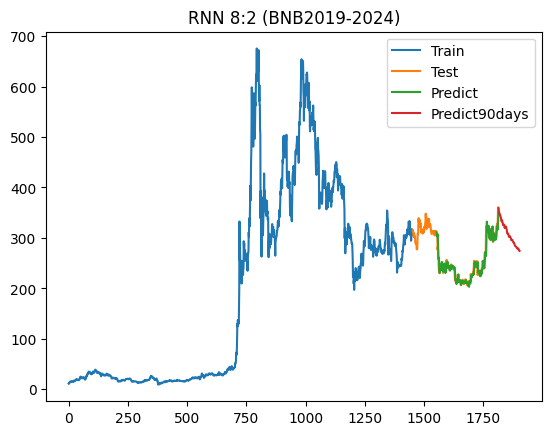

In [21]:
plt.title('RNN 8:2 (BNB2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect90days_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect90days_data_index,scaler.inverse_transform(lst_output))  # Vẽ dự đoán cho 90 ngày
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()